# Basic SPA
Simulating the SPA, i.e. transferring molecules from J = 0 to J = 2 using microwave driven adiabatic passage. Taking the microwave beam distributions to be perfect Gaussians and no scattered microwaves. Used for making illustrations.

## Import packages

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
from itertools import product
from pathlib import Path
import random
import string
import time


from joblib import Parallel, delayed
import matplotlib.pyplot as plt

# plt.style.use(["seaborn-darkgrid", "thesis"])

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
# # import seaborn as sns

import centrex_tlf
from centrex_tlf.states import UncoupledBasisState, ElectronicState, ElectronicState

# from state_prep.utils import calculate_transition_frequency
from state_prep.electric_fields import ElectricField, E_field_ring, Ez_from_csv
from state_prep.hamiltonians import SlowHamiltonian, SlowHamiltonianOld
from state_prep.intensity_profiles import GaussianBeam, MeasuredBeam, BackgroundField
from state_prep.magnetic_fields import MagneticField
from state_prep.microwaves import Polarization, Intensity, MicrowaveField
from state_prep.plotters import CouplingPlotter
from state_prep.simulator import Simulator
from state_prep.trajectory import Trajectory
from state_prep.utils import vector_to_state, calculate_transition_frequency

## Define molecule trajectory
Defining the molecule trajectory as a Trajectory object. Specifying the initial position as z = 50 mm, i.e. 50mm  after the center of the microwaves is, and on the axis of the beamline. Taking the beam velocity to be 200 m/s in the z-direction. The simulation ends when `zfin` is reached, 200 mm from the microwwaves.

In [42]:
trajectory = Trajectory(
    Rini=np.array((0, 0, -80e-3)), Vini=np.array((0, 0, 200.0)), zfin=80e-3
)

## Define electric field
Defining an electric field that is an approximation of what the molecules should see in the real experiment.

In [43]:
# Define positions for centers of ring electrodes (in m)
electrode_offset = 0.0
z1 = -85.725e-3 + electrode_offset
z2 = 85.725e-3 + electrode_offset

# Define voltages on the rings
V1 = 5e3 * 172 / 155
V2 = V1 * 0.07

# Define a quickly decaying function to simulate adding shielding between state prep region and detection region
decay_function = lambda R, Z0, l: np.exp(
    -0.5 * ((R[2] - Z0) * float(R[2] > Z0) / l) ** 2
)
decay_tanh = lambda R, Z0, l, z_shield: 0.5 * (1 - np.tanh((R[2] - Z0) / l))

# Define electric field as function of position
z_shield = 0.085
l_decay = 0.02
z0 = 116.4 / 1e3

E_R = lambda R: (
    (E_field_ring(R, z0=z1, V=V1) + E_field_ring(R, z0=z2, V=V2))
    * decay_tanh(R, z0, l_decay, z_shield)
)


# Define electric field based on finite element simulations
# Ez = Ez_from_csv()
# E_R = lambda R: np.array([0,0,Ez(R[2])])


electric_field = ElectricField(E_R, trajectory.R_t)

Max electric field: 270.04 V/cm
Electric field at z = 1.125'': 111.08 V/cm


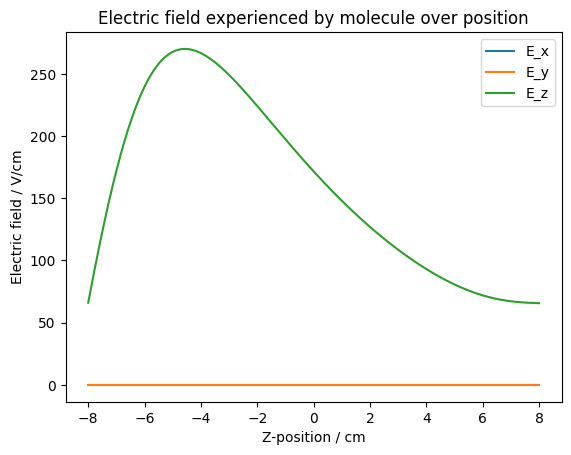

In [44]:
# Plot the electric field as a check:
ts, Es, ax = electric_field.plot(trajectory, position=True)

print(f"Max electric field: {np.max(Es):.2f} V/cm")
print(
    f"Electric field at z = 1.125'': {E_R(np.array([0, 0, 0.0254 * 1.125]))[2]:.2f} V/cm"
)

## Define magnetic field
Define the magnetic field. Using a constant field, either a nominal small field (so mF states become non-degenerate eigenstates of the Hamiltonian) or something resembilng Earth's magnetic field.

In [45]:
B = np.array((0, 0, 1e-3))


# B = np.array((0.2,0.45,0.1))
def B_R(R):
    if len(R.shape) == 1:
        return B
    else:
        return B.reshape((3, 1)) * np.ones(R.shape)


magnetic_field = MagneticField(B_R, R_t=trajectory.R_t)

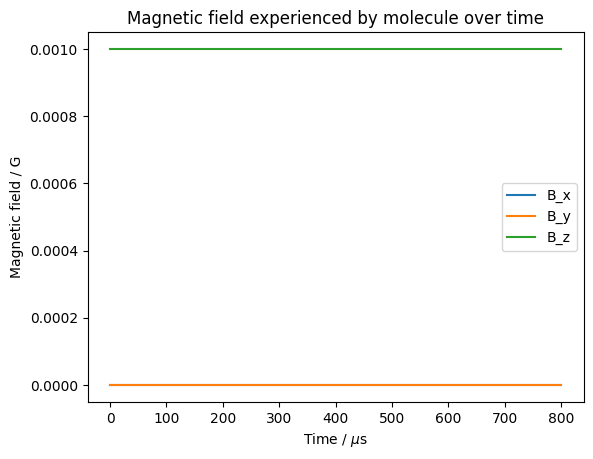

In [46]:
magnetic_field.plot(trajectory)

## Initial and final states
Define approximate initial states here.

In [49]:
# Define some useful approximate states
J0_singlet = (
    1
    / np.sqrt(2)
    * (
        1
        * UncoupledBasisState(
            J=0,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=+1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
        - 1
        * UncoupledBasisState(
            J=0,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=+1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
    )
)

J0_triplet_0 = (
    1
    / np.sqrt(2)
    * (
        1
        * UncoupledBasisState(
            J=0,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=+1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
        + 1
        * UncoupledBasisState(
            J=0,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=+1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
    )
)

J0_triplet_p = 1 * UncoupledBasisState(
    J=0,
    mJ=0,
    I1=1 / 2,
    m1=1 / 2,
    I2=1 / 2,
    m2=1 / 2,
    P=+1,
    Omega=0,
    electronic_state=ElectronicState.X,
)

J0_triplet_m = 1 * UncoupledBasisState(
    J=0,
    mJ=0,
    I1=1 / 2,
    m1=-1 / 2,
    I2=1 / 2,
    m2=-1 / 2,
    P=+1,
    Omega=0,
    electronic_state=ElectronicState.X,
)

initial_states_approx = [J0_singlet, J0_triplet_m, J0_triplet_0, J0_triplet_p]

In [50]:
# Define some useful approximate states
J1_singlet = (
    1
    / np.sqrt(2)
    * (
        1
        * UncoupledBasisState(
            J=1,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=-1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
        - 1
        * UncoupledBasisState(
            J=1,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=-1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
    )
)

J1_triplet_0 = (
    1
    / np.sqrt(2)
    * (
        1
        * UncoupledBasisState(
            J=1,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=-1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
        + 1
        * UncoupledBasisState(
            J=1,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=-1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
    )
)

J1_triplet_p = 1 * UncoupledBasisState(
    J=1,
    mJ=0,
    I1=1 / 2,
    m1=1 / 2,
    I2=1 / 2,
    m2=1 / 2,
    P=-1,
    Omega=0,
    electronic_state=ElectronicState.X,
)

J1_triplet_m = 1 * UncoupledBasisState(
    J=1,
    mJ=0,
    I1=1 / 2,
    m1=-1 / 2,
    I2=1 / 2,
    m2=-1 / 2,
    P=-1,
    Omega=0,
    electronic_state=ElectronicState.X,
)

# initial_states_approx = [J1_singlet, J1_triplet_m, J1_triplet_0, J1_triplet_p]

In [51]:
# Define some useful approximate states
J2_singlet = (
    1
    / np.sqrt(2)
    * (
        1
        * UncoupledBasisState(
            J=2,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
        - 1
        * UncoupledBasisState(
            J=2,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
    )
)

J2_triplet_0 = (
    1
    / np.sqrt(2)
    * (
        1
        * UncoupledBasisState(
            J=2,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
        + 1
        * UncoupledBasisState(
            J=2,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
    )
)

J2_triplet_p = 1 * UncoupledBasisState(
    J=2,
    mJ=0,
    I1=1 / 2,
    m1=1 / 2,
    I2=1 / 2,
    m2=1 / 2,
    P=1,
    Omega=0,
    electronic_state=ElectronicState.X,
)

J2_triplet_m = 1 * UncoupledBasisState(
    J=2,
    mJ=0,
    I1=1 / 2,
    m1=-1 / 2,
    I2=1 / 2,
    m2=-1 / 2,
    P=1,
    Omega=0,
    electronic_state=ElectronicState.X,
)

final_states_approx = [J2_singlet, J2_triplet_m, J2_triplet_0, J2_triplet_p]

## Define slowly varying Hamiltonian
Define a Hamiltonian object that represents the slowly varying part of the Hamiltonian (i.e. everything except the microwaves). Using J = 0-3 here since we're interested in the time-evolution of J = 0 and 1 states; J = 0 and 3 are absolutely required since the electric field couples J = 0 to these, J = 3 is not strictly necessary. Since the Stark energies are << the rotational energies, we mostly just need the J of interest $\pm 1$.

In [52]:
Js = [0, 1, 2, 3]
hamiltonian = SlowHamiltonian(Js, trajectory, electric_field, magnetic_field)
# hamiltonian = SlowHamiltonianOld(0, 3, trajectory, electric_field, magnetic_field, '../hamiltonians/TlF_X_state_hamiltonian0to3_2020_03_03.pickle')

## Define microwave Hamiltonian
We will define a microwave field with the following properties
- A Gaussian spatial profile with 1'' intensity FWHM (cylindrically symmetric) 
- propagating along the X-direction
- polarized along the Z-direction
- Calculate power based on the desired Rabi rate for the desired transition

### J = 0 to 1 microwaves

In [181]:
# Define states
state1 = J0_singlet
state2 = J1_singlet

# Center position
R0 = np.array((0.00, 0, -0.0))

#### Polarization:
# Define polarization components
p_x = np.array([1, 0, 0])
p_y = np.array([0, 1, 0])
p_z = np.array([0, 0, 1])

# Define a function that gives the main component of the polarization as a function of position
p_main = p_z + 0.0 * p_y
P_R = lambda R: p_main / np.sqrt(np.sum(p_main**2))

# Define k-vector
k = np.array((1, 0, 0))
pol = Polarization(P_R, k, f_long=0)

#### Frequency
# Calculate the microwave frequency between specified states at a specific point
detuning_1 = 0
muW_freq_1 = (
    calculate_transition_frequency(state1, state2, hamiltonian.H_R(R0), hamiltonian.QN)
    + detuning_1
)
print(f"Transition frequency at center of SPA1 microwaves: {muW_freq_1 / 1e9:.5f} GHz")

#### Intensity profile:
# Define a Gaussian intensity profile
# intensity = MeasuredBeam(power = 1e-3, sigma = 1*25.4e-3/(2*np.sqrt(2*np.log(2))), R0 = R0, k = k, freq = muW_freq)
intensity = GaussianBeam(
    power=0.2e-3,
    sigma=1 * 25.4e-3 / (2 * np.sqrt(2 * np.log(2))),
    R0=R0,
    k=k,
    freq=muW_freq_1,
)

#### Define MicrowaveField
mf01 = MicrowaveField(0, 1, intensity, pol, muW_freq_1, hamiltonian.QN)

Transition frequency at center of SPA1 microwaves: 13.34000 GHz


In [182]:
mf01.calculate_rabi_rate(state1, state2, 0.2e-3, R0) / (2 * np.pi * 1e3)

np.float64(88.22011598843173)

### J = 1 to 2 microwaves

In [183]:
# Define states
state1 = J1_singlet
state2 = J2_singlet

# Center position
R0 = np.array((0.00, 0, 0.0254 * 1.125))

#### Polarization:
# Define polarization components
p_x = np.array([1, 0, 0])
p_y = np.array([0, 1, 0])
p_z = np.array([0, 0, 1])

# Define a function that gives the main component of the polarization as a function of position
p_main = p_z + 0.0 * p_y
P_R = lambda R: p_main / np.sqrt(np.sum(p_main**2))

# Define k-vector
k = np.array((1, 0, 0))
pol = Polarization(P_R, k, f_long=0)

#### Frequency
# Calculate the microwave frequency between specified states at a specific point
muW_freq_2 = calculate_transition_frequency(
    state1, state2, hamiltonian.H_R(R0), hamiltonian.QN
)
print(f"Transition frequency at center of SPA2 microwaves: {muW_freq_2 / 1e9:.5f} GHz")

#### Intensity profile:
# Define a Gaussian intensity profile
# intensity = MeasuredBeam(power = 1e-3, sigma = 1*25.4e-3/(2*np.sqrt(2*np.log(2))), R0 = R0, k = k, freq = muW_freq)
intensity = GaussianBeam(
    power=0.2e-3,
    sigma=1 * 25.4e-3 / (2 * np.sqrt(2 * np.log(2))),
    R0=R0,
    k=k,
    freq=muW_freq_2,
)

#### Define MicrowaveField
mf12 = MicrowaveField(1, 2, intensity, pol, muW_freq_2, hamiltonian.QN)

Transition frequency at center of SPA2 microwaves: 26.66875 GHz


In [184]:
mf12.calculate_rabi_rate(state1, state2, 0.05e-3, R0) / (2 * np.pi * 1e3)

np.float64(39.45323526660989)

### Define list of microwave fields

In [185]:
microwave_fields = [mf01, mf12]

## Time-evolution
Next define a Simulator and use it to numerically integrate the Schroedinger equation to see how the states evolve as the electric field is ramped down. 

In [186]:
simulator = Simulator(
    trajectory,
    electric_field,
    magnetic_field,
    initial_states_approx,
    hamiltonian,
    microwave_fields,
)

In [187]:
# Set microwave parameters
## Center postion
R0 = np.array([0.00, 0, 0.0254 * 1.125])

## Sigma
mf12.intensity.sigma = 1.0 * 25.4e-3 / (2 * np.sqrt(2 * np.log(2)))

## Frequency
freq = calculate_transition_frequency(
    state1, state2, hamiltonian.H_R(R0), hamiltonian.QN
)
detuning = 0
mf12.set_frequency(freq + detuning)
mf12.set_position(R0)

## Power
# mf01.calculate_microwave_power(state1, state2, 2*np.pi*100e3, R0)
mf12.set_power(5e-5)

# Molecule parameters
trajectory.Rini = np.array([0, 0.00, -80e-3])
trajectory.Vini = np.array([0, 0, 184])
trajectory.zfin = 100e-3


In [188]:
result = simulator.run(N_steps=10000)

100%|██████████| 9999/9999 [00:44<00:00, 223.94it/s]


## Plot results

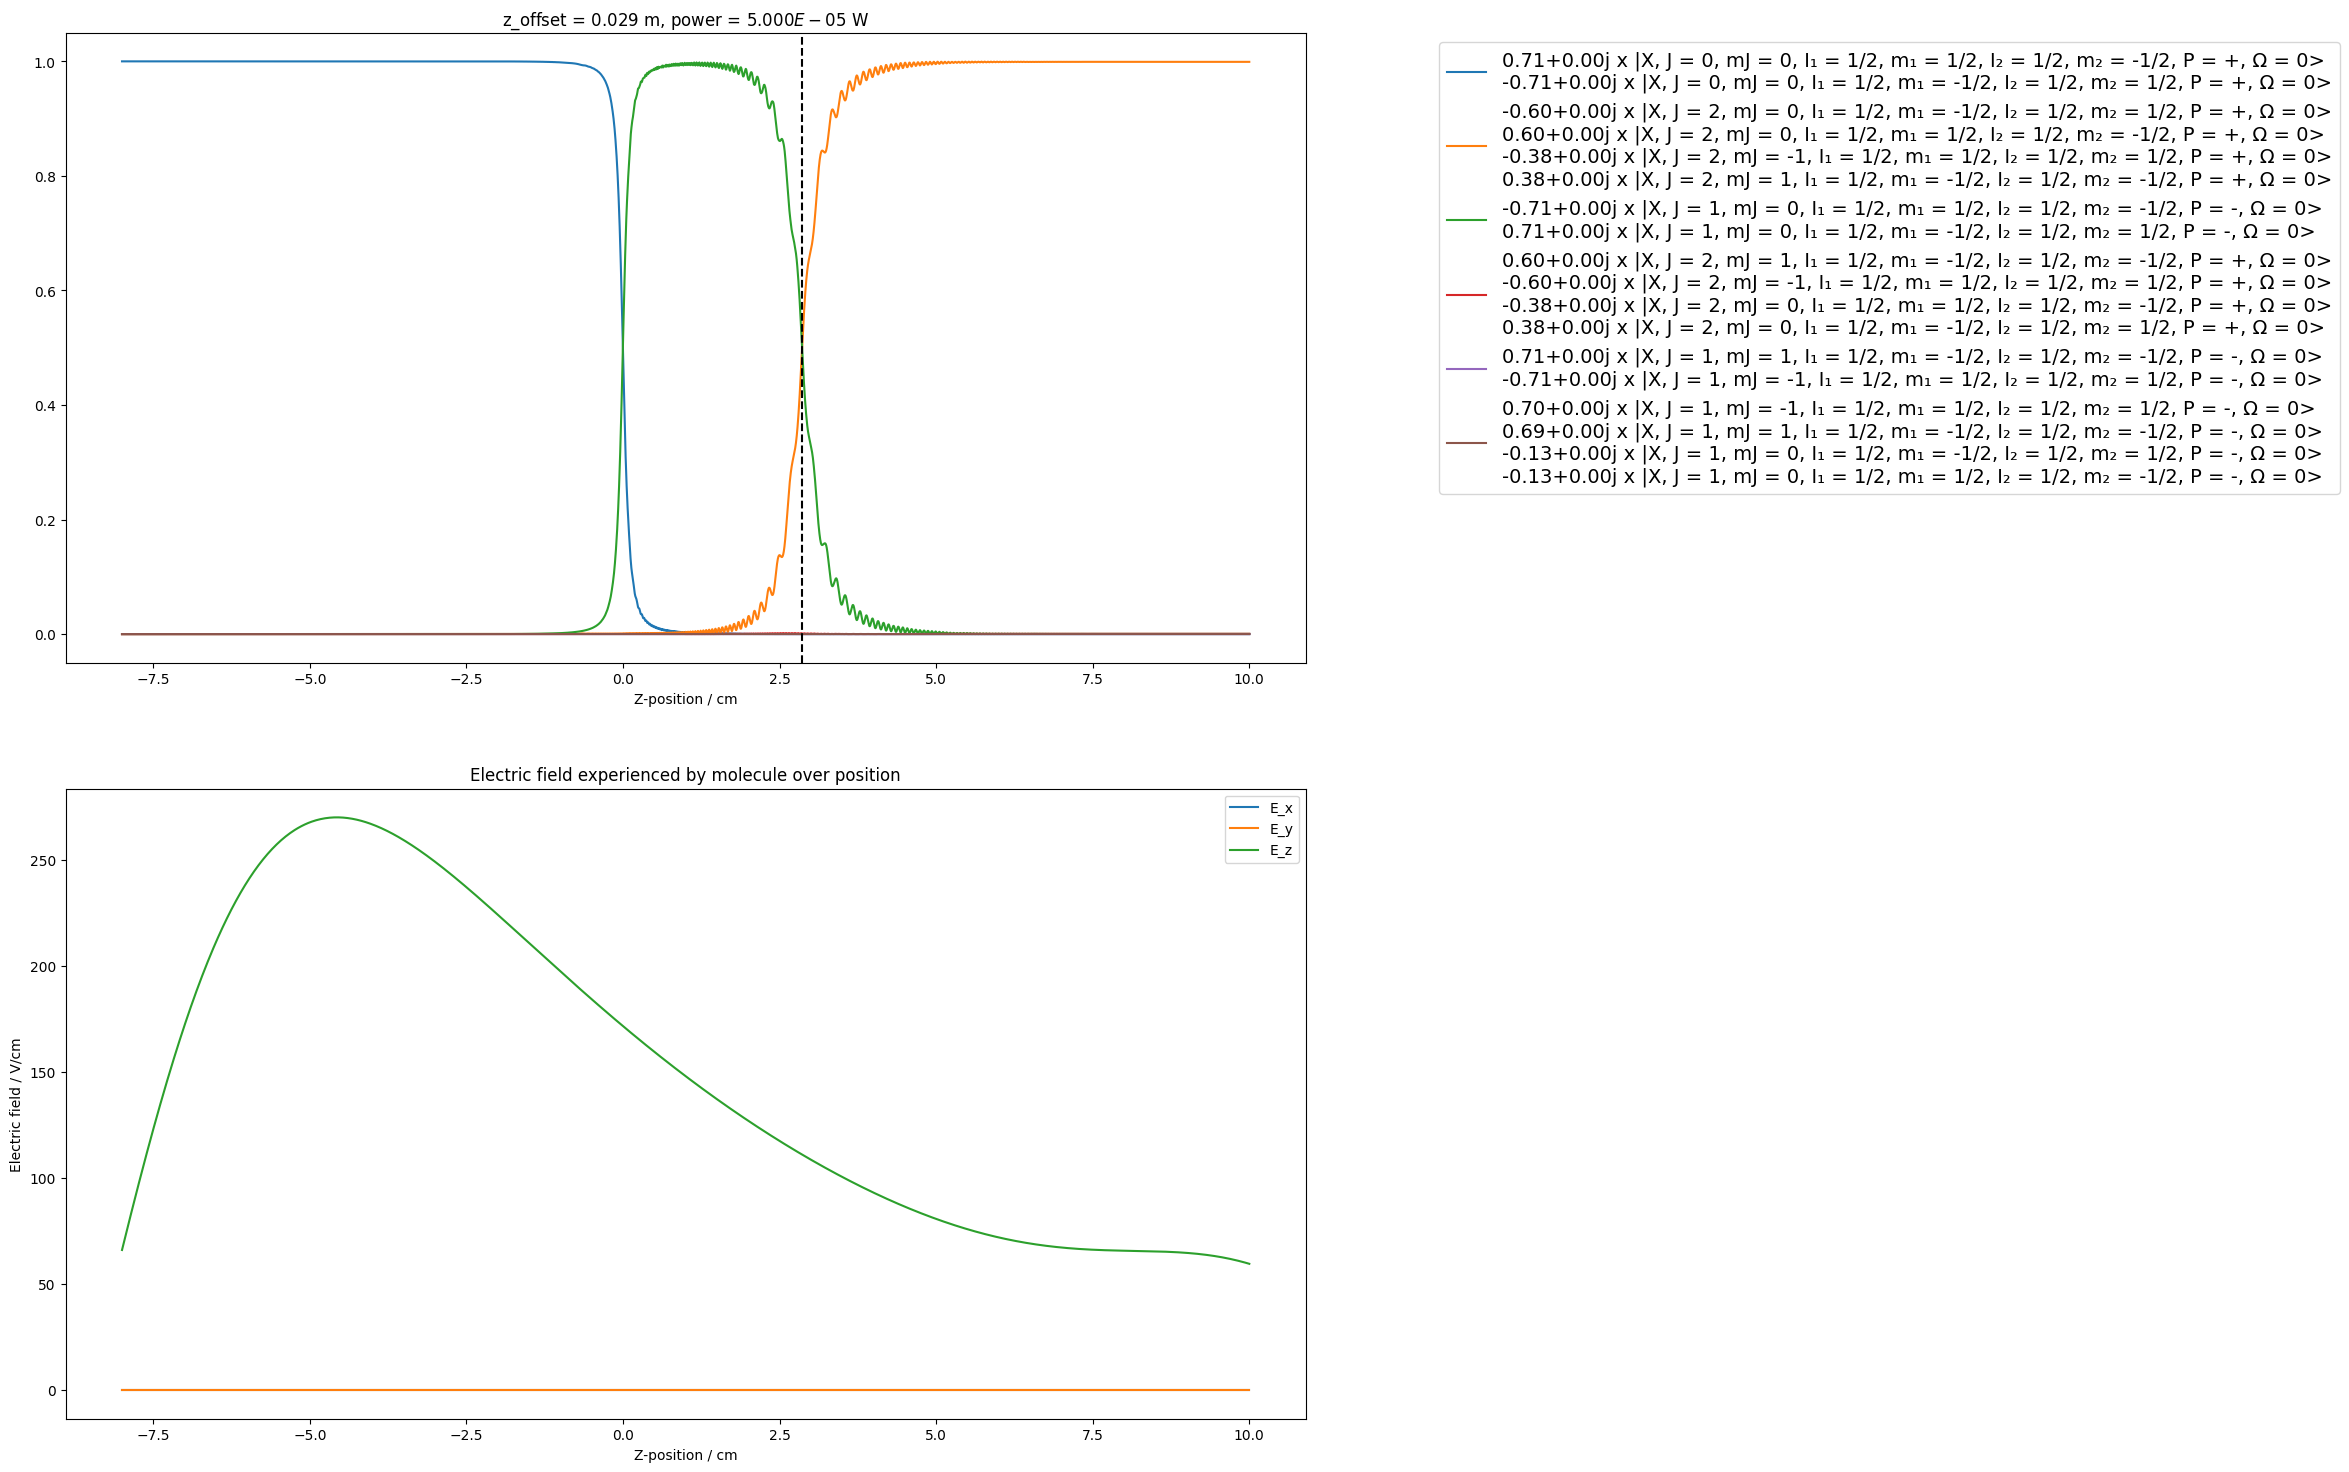

In [189]:
initial_state = result.initial_states[0]
large_prob_states = result.find_large_prob_states(initial_state, N=6)
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(16, 18))
result.plot_state_probabilities(large_prob_states, initial_state, ax=ax, position=True)
ax.legend(fontsize=14, bbox_to_anchor=(1.1, 1))
ax.axvline(x=R0[2] * 1e2, ls="--", c="k")
ax.set_title(f"z_offset = ${R0[2]:.3f}$ m, power = ${mf12.intensity.power:.3E}$ W")

Es, _, _ = electric_field.plot(trajectory, position=True, ax=ax2)

### Plot intensity profile
Check that the longitudinal polarization appears correctly

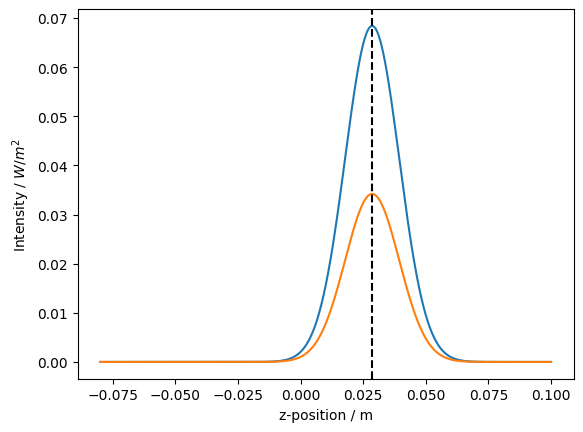

In [190]:
t_array = np.linspace(0, trajectory.get_T(), 1000)
Rs = np.array([trajectory.R_t(t) for t in t_array])
intensities_R = np.array([mf12.intensity.I_R(trajectory.R_t(t)) for t in t_array])
intensities = np.array(
    [mf12.intensity.I_R(np.array([0.0, 0.0127, z])) for z in Rs[:, 2]]
)

fig, ax = plt.subplots()
ax.plot(Rs[:, 2], intensities_R)
ax.plot(Rs[:, 2], intensities)
ax.set_xlabel("z-position / m")
ax.set_ylabel(r"Intensity / $W/m^2$")
ax.axvline(x=R0[2], ls="--", c="k")

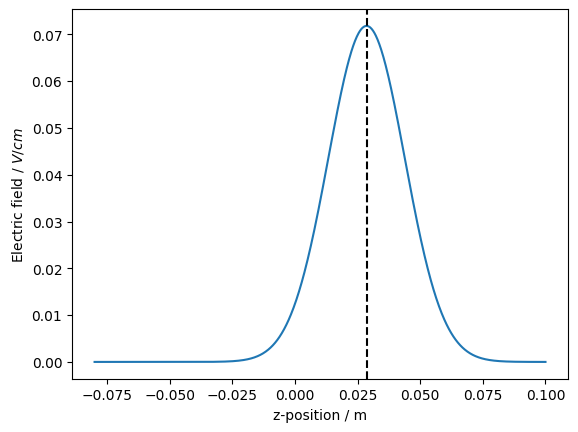

In [191]:
E_mags_R = np.array([mf12.intensity.E_R(trajectory.R_t(t)) for t in t_array])
E_mags = np.array([mf12.intensity.E_R(np.array((0.0, 0.0, z))) for z in Rs[:, 2]])

fig, ax = plt.subplots()
ax.plot(Rs[:, 2], E_mags_R)
# ax.plot(Rs[:,2], E_mags)
ax.set_xlabel("z-position / m")
ax.set_ylabel(r"Electric field / $V/cm$")
ax.axvline(x=R0[2], ls="--", c="k")

### Plot polarization components as function of position
Check that the longitudinal polarization appears correctly

c:\Users\ogras\anaconda3\envs\centrex-eql\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\ogras\anaconda3\envs\centrex-eql\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


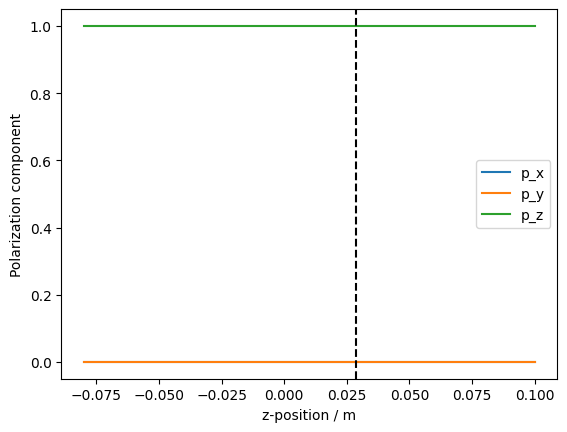

In [192]:
pols = np.array(
    [
        mf12.polarization.p_R(trajectory.R_t(t), mf12.intensity, freq=muW_freq_2)
        for t in t_array
    ]
)

fig, ax = plt.subplots()
ax.plot(Rs[:, 2], np.imag(pols[:, 0]), label="p_x")
ax.plot(Rs[:, 2], pols[:, 1], label="p_y")
ax.plot(Rs[:, 2], np.real(pols[:, 2]), label="p_z")
ax.legend()
ax.set_xlabel("z-position / m")
ax.set_ylabel("Polarization component")
ax.axvline(x=R0[2], ls="--", c="k")

### Nice plot for paper

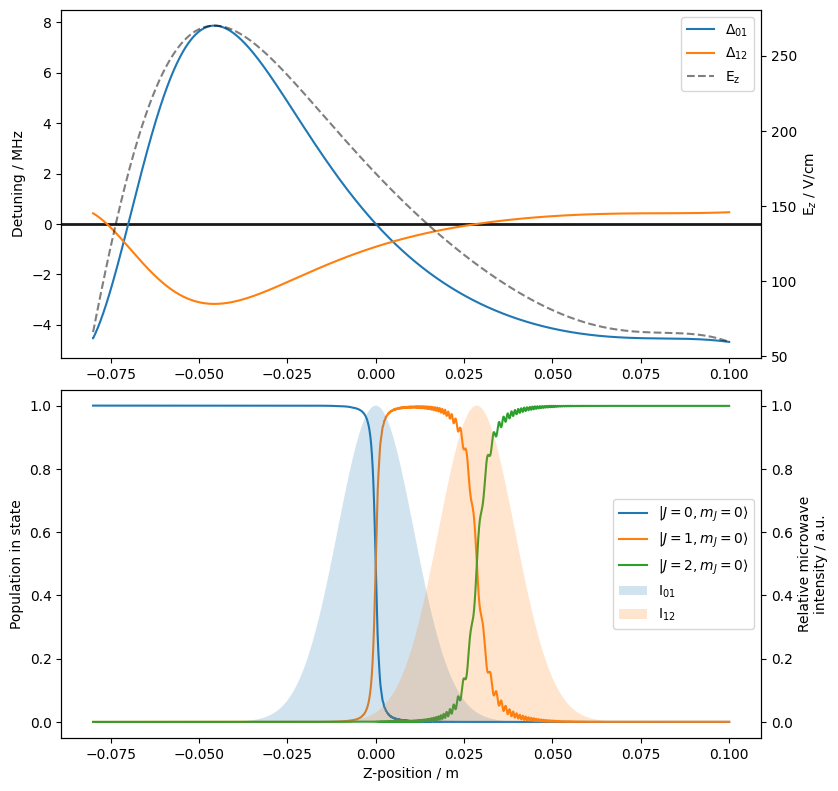

In [193]:
# Set up plot
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(210 / 25.4, 297 * 2 / 3 / 25.4), constrained_layout=True
)

# Add some extra space between axes
# plt.subplots_adjust(hspace = 0.5)


# Find detunings
E0 = result.get_state_energy(J0_singlet)
E1 = result.get_state_energy(J1_singlet)
E2 = result.get_state_energy(J2_singlet)

D01 = (E1 - E0) / (2 * np.pi * 1e6) - muW_freq_1 / 1e6
D12 = (E2 - E1) / (2 * np.pi * 1e6) - muW_freq_2 / 1e6

# Find electric field
Ezs = np.array([electric_field.E_R(trajectory.R_t(t))[2] for t in result.t_array])

# Find intensities for each microwave
I01 = np.array(
    [mf01.intensity.I_R(trajectory.R_t(t)) for t in result.t_array]
) / mf01.intensity.I_R(np.array((0, 0, 0)))
I12 = np.array(
    [mf12.intensity.I_R(trajectory.R_t(t)) for t in result.t_array]
) / mf12.intensity.I_R(np.array([0.00, 0, 0.0254 * 1.125]))

# Find probabilities for each state
P0 = result.get_state_probability(J0_singlet, initial_state=result.initial_states[0])
P1 = result.get_state_probability(J1_singlet, initial_state=result.initial_states[0])
P2 = result.get_state_probability(J2_singlet, initial_state=result.initial_states[0])

# Plot electric field
ax1_twin = ax1.twinx()
ax1_twin.grid(False)
l11 = ax1_twin.plot(result.z_array, Ezs, "k--", alpha=0.5, label=r"$\mathrm{E_z}$")

# Plot detunings
ax1.axhline(0, c="k", lw=2, alpha=0.9)
l12 = ax1.plot(result.z_array, D01, label=r"$\Delta_{01}$")
l13 = ax1.plot(result.z_array, D12, label=r"$\Delta_{12}$")

# Plot intensities
ax2_twin = ax2.twinx()
ax2_twin.grid(False)
l21 = ax2_twin.fill_between(result.z_array, I01, label=r"I$_{01}$", alpha=0.2)
l22 = ax2_twin.fill_between(result.z_array, I12, label=r"I$_{12}$", alpha=0.2)

# Plot state probabilities
l23 = ax2.plot(result.z_array, P0, label=r"$|J = 0, m_J = 0\rangle$")
l24 = ax2.plot(result.z_array, P1, label=r"$|J = 1, m_J = 0\rangle$")
l25 = ax2.plot(result.z_array, P2, label=r"$|J = 2, m_J = 0\rangle$")

# Add axis labes
ax1.set_ylabel("Detuning / MHz")
ax1_twin.set_ylabel(r"E$_z$ / V/cm")
ax2.set_xlabel("Z-position / m")
ax2.set_ylabel("Population in state")
ax2_twin.set_ylabel("Relative microwave\nintensity / a.u.")

# Make legends
lns1 = l12 + l13 + l11
lbs1 = [l.get_label() for l in lns1]
ax1.legend(lns1, lbs1)

lns2 = l23 + l24 + l25 + [l21] + [l22]
lbs2 = [l.get_label() for l in lns2]
ax2.legend(lns2, lbs2)

# Save the figure
# plt.savefig('../../../figures/naive_state_evolution.pdf')

# ALso save the data for the plot
df = pd.DataFrame(
    {
        "z_pos": result.z_array,
        "D01": D01,
        "D12": D12,
        "Ez": Ezs,
        "I01": I01,
        "I12": I12,
        "P0": P0,
        "P1": P1,
        "P2": P2,
    }
)

# df.to_csv('../../../figures/data/data_naive_state_evolution.csv')